# Knowledge Graph Completion

Knowledge Graph Completion (KGC) is the process of enhancing or enriching a knowledge graph by predicting and filling in missing information (links or nodes). A knowledge graph represents relationships between entities in the form of a graph, where entities are nodes and relationships are edges. However, real-world knowledge graphs are often incomplete, with many potential links missing. KGC aims to infer these missing links or facts by leveraging existing data and patterns in the graph.

### Key Concepts:

-   Entities: Represent real-world objects (e.g., people, places, organizations).
-   Relations: The connections between entities (e.g., "works_for", "located_in").
-   Triples: The fundamental unit of a knowledge graph, typically in the form of $(h, r, t)$, where:
    -   $ h $ (head) is the starting entity.
    -   $ r $ (relation) describes the type of connection.
    -   $ t $ (tail) is the target entity.
    -   Example: $(\text{Einstein}, \text{invented}, \text{Theory of Relativity})$.

### Example of Completion:

Given a knowledge graph with the triple:

-   $(\text{Paris}, \text{capital\_of}, ?)$

    KGC would predict that the missing entity is "France."

### Techniques for Knowledge Graph Completion:

1. Embedding-Based Methods:
    - Translate entities and relations into a continuous vector space.
    - Models: TransE, TransH, DistMult, ComplEx.
2. Rule-Based Approaches:
    - Learn logical rules from the graph to infer missing links.
    - Example: If $A \rightarrow B$ and $B \rightarrow C$, then $A \rightarrow C$.
3. Graph Neural Networks (GNNs):
    - Leverage neural networks to learn from the graph structure.
4. Probabilistic Models:
    - Predict links based on statistical and probabilistic relationships.
5. Neuro-symbolic Approaches:
    - Combine symbolic reasoning with neural networks for better interpretability.
6. Large Language Models (LLMs):
    - Use LLMs to extract triples from text or predict missing relations directly.
    - Techniques: Fine-tuning on graph data, prompt-based triple prediction, embedding extraction.

### Applications of KGC:

-   Recommendation Systems: Predict user preferences by completing user-item interaction graphs.
-   Healthcare: Fill missing links in biomedical knowledge graphs for drug discovery.
-   Search Engines: Enhance search capabilities by improving knowledge graph coverage.
-   Finance: Predict links between entities for fraud detection or market analysis.


# PyKEEN and Neo4j for multi-class link prediction using knowledge graph embedding models

This notebook demonstrates how to perform knowledge graph completion, focusing on multi-class link prediction. Unlike standard link prediction, which predicts the existence of a link, multi-class link prediction also classifies the type of relationship between entities.

To apply this method, the knowledge graph must contain multiple relationship types. If the graph has only one type of relationship, standard [link prediction techniques](https://towardsdatascience.com/a-deep-dive-into-neo4j-link-prediction-pipeline-and-fastrp-embedding-algorithm-bf244aeed50d) or alternative approaches that do not require relationship classification may be more suitable.

For multi-class link prediction, we employ knowledge graph embedding models rather than traditional node embedding models. The key distinction lies in their scope:

-   Node embedding models generate embeddings solely for nodes.
-   Knowledge graph embedding models create embeddings for both nodes and relationships.

In knowledge graph embedding, the conventional notation is:

-   $h$ – head (starting node)
-   $r$ – relationship (edge)
-   $t$ – tail (target node)

The core idea is that if a relationship exists between nodes, the embedding of the head node ($h$) plus the embedding of the relationship ($r$) should approximate the embedding of the tail node ($t$): $h + r \approx t$

Prediction follows intuitively from this principle. To infer new relationships for a node, sum the node's embedding with the embedding of a candidate relationship, then evaluate which nodes are closest to the result in the embedding space.


# Neo4j Desktop

To follow along with this notebook, ensure that the Neo4j Desktop application is installed.

Neo4j is a leading graph database platform designed to efficiently store, manage, and query data that is highly interconnected. Unlike traditional relational databases, Neo4j uses a property graph model where data is represented as nodes (entities), edges (relationships), and properties (attributes). This structure makes Neo4j particularly well-suited for applications involving complex relationships, such as knowledge graphs, social networks, fraud detection, and recommendation systems.

Key Features of Neo4j:

-   Native Graph Storage and Processing – Optimized for handling graph data directly.
-   Cypher Query Language – A powerful, declarative language designed for graph traversal and pattern matching.
-   Scalability and Performance – Handles large-scale data while maintaining high performance for complex queries.
-   Visualization Tools – Enables intuitive visualization of graph structures and relationships.
-   Extensibility – Supports integration with various tools, plugins, and programming languages.

After installing Neo4j Desktop, download a database dump and restore it to create a database instance. For this demonstration, you can use a [subset of the Hetionet](https://drive.google.com/file/d/1u34cFBYvBtdBsqOUPdmbcIyIt88IiZYe/view?usp=sharing), a knowledge graph containing information on genes, compounds, and diseases. This dataset includes numerous relationships between entities, primarily within the biomedical domain. While a deep understanding of these relationships may require domain expertise, we will focus on the treats relationship, which links compounds to diseases.

<div style="border: 2px solid orange; background-color: #f9c74f; max-width: 80%; padding: 15px; border-radius: 8px; font-family: Arial, sans-serif; color: black; box-sizing: border-box;">

<strong>Disclaimer:</strong> The dump of the subset of the Hetionet requires version $4.3$.

</div>

In this notebook, we will apply knowledge graph embedding models to predict new treats relationships, simulating a drug repurposing task – identifying potential new uses for existing drugs based on inferred connections within the graph.

# PyKEEN

[PyKEEN](https://pykeen.readthedocs.io/en/stable/index.html) (Python Knowledge Embedding Engine) is an open-source Python library for training and evaluating knowledge graph embedding (KGE) models. It simplifies the application of machine learning to knowledge graphs by providing pre-implemented models, training pipelines, and evaluation tools.  

## Key Features:  

- Model Support: Includes models like TransE, DistMult, ComplEx, and RotatE.  
- Modular and Customizable: Easily mix, match, and extend components.  
- Automation: Handles hyperparameter tuning, training, and evaluation.  
- Benchmarking: Compares model performance across datasets.  
- Visualization: Offers tools to analyze embeddings and results.  

## Use Cases:  

- Knowledge Graph Completion: Predict missing links and relationship types.  
- Link Prediction: Identify potential connections between entities.  
- Node Classification: Infer properties or classes for nodes.  
- Recommender Systems: Suggest related items by predicting links.  
- Biomedical and NLP Applications: Predict interactions, enhance search, and retrieve information.  

PyKEEN is widely used in fields like healthcare, social networks, and recommendation systems for knowledge graph analysis and enrichment.

# Imports

In [1]:
import pandas as pd
from neo4j import GraphDatabase
from pykeen import predict
from pykeen.evaluation import RankBasedEvaluator
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

# Hyperparameter definitions

The next cell establishes a connection to the Neo4j database.

In [2]:
# Define Neo4j connections
host = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
driver = GraphDatabase.driver(host, auth=(user, password))

# Auxiliary functions

The `run_query` function executes a Cypher query and returns the results as a Pandas DataFrame.

In [3]:
def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Transform a Neo4j to a PyKEEN

First, we will convert the Neo4j graph into a PyKEEN-compatible format and split the data into training and testing sets.

In [4]:
data = run_query(
    """
    MATCH (s)-[r]->(t)
    RETURN toString(id(s)) as source, toString(id(t)) AS target, type(r) as type
    """
)

In [5]:
data.head()

,source,target,type
0,0,12590,interacts
1,0,8752,interacts
2,0,7915,interacts
3,0,21711,interacts
4,0,6447,interacts


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561721 entries, 0 to 561720
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   source  561721 non-null  object
 1   target  561721 non-null  object
 2   type    561721 non-null  object
dtypes: object(3)
memory usage: 12.9+ MB


In [7]:
data.describe()

,source,target,type
count,561721,561721,561721
unique,16210,18891,10
top,21711,21711,regulates
freq,6128,2663,265672


PyKEEN provides the [`from_labeled_triples`](https://pykeen.readthedocs.io/en/stable/api/pykeen.triples.TriplesFactory.html#pykeen.triples.TriplesFactory.from_labeled_triples) method, which constructs a graph from a list of input triples.

In [8]:
tf = TriplesFactory.from_labeled_triples(
    data[["source", "type", "target"]].values, compact_id=False
)

This example uses a generic Cypher query to fetch data from any Neo4j dataset and construct a PyKEEN graph. The query retrieves the internal Neo4j node IDs to build the triples DataFrame. Since PyKEEN requires all elements in the triples to be strings, the internal IDs are cast to strings. With the PyKEEN graph constructed, the `split` method is used to partition the data into training and testing sets.

In [9]:
training, testing, validation = tf.split([0.8, 0.1, 0.1])

using automatically assigned random_state=872719975


# Train a knowledge graph embedding model

With the train-test data prepared, we can proceed to train a knowledge graph embedding model. In this example, we will use the RotatE model. To keep the tutorial simple, no hyperparameter optimization will be performed. The model will be trained for $20$ epochs with an embedding dimension of $128$.

It's worth noting that $20$ epochs may be insufficient for meaningful training on large or complex graphs, especially with a high embedding dimensionality. Additionally, applying early stopping in this scenario is unlikely to yield significant improvements due to the limited number of epochs.

In [10]:
result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="RotatE",
    stopper="early",
    epochs=20,
    dimensions=128,
    random_seed=420,
)

Training epochs on cuda:0:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 626.95s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.08114218574760117. Saved model weights to C:\Users\willf\.data\pykeen\checkpoints\best-model-weights-aaa35713-58fc-4513-b8c6-590873b47cd0.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1756 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 553.07s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.090960069784416. Saved model weights to C:\Users\willf\.data\pykeen\checkpoints\best-model-weights-aaa35713-58fc-4513-b8c6-590873b47cd0.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Evaluating on cuda:0:   0%|          | 0.00/56.2k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 538.63s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

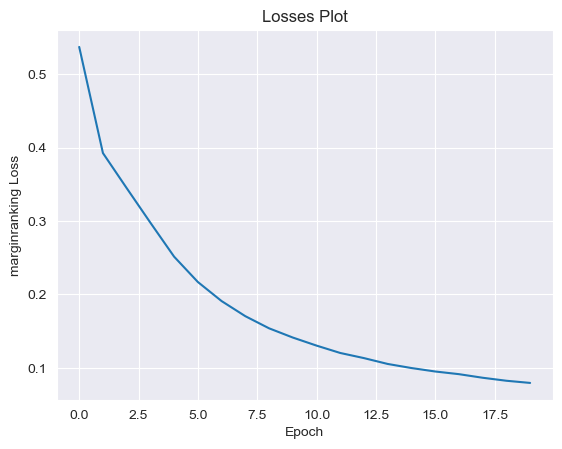

In [11]:
result.plot_losses()

In [ ]:
# The result object also contains the evaluation metrics result.metric_results.to_df()

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(
    result.model,
    testing.mapped_triples,
    additional_filter_triples=[training.mapped_triples, validation.mapped_triples],
)

In [24]:
# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Rank: {metrics.get_metric('mean_rank')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Hits@1: 0.02186142562130599
Hits@3: 0.048209072135583564
Hits@5: 0.06572669657480595
Hits@10: 0.09874136580502742
Mean Rank: 1349.611328125
Mean Reciprocal Rank: 0.04981667175889015


# Multi-class link prediction

The PyKEEN library provides several approaches for multi-class link prediction. These approaches enable the identification of the top-K predicted links within the network or allow for more targeted predictions by specifying a particular head node and relationship type to evaluate potential novel connections.

In this example, the objective is to predict new treats relationships associated with the compound L-Asparagine. As the graph mapping utilizes internal Neo4j node IDs, it is necessary to first query the database to obtain the corresponding node ID for L-Asparagine. This ID is subsequently used as input for the prediction method to generate relevant link predictions.

In [13]:
compound_id = run_query(
    """
    MATCH (s:Compound)
    WHERE s.name = $compound
    RETURN toString(id(s)) as id
    """,
    {"compound": "L-Asparagine"}
)["id"][0]

In [14]:
df = (
    predict.predict_target(
        result.model,
        head=compound_id,
        relation="treats",
        triples_factory=result.training,
    )
    .add_membership_columns(training=training, testing=testing, validation=validation)
    .df
)

print(df.head(5))

       tail_id     score tail_label  in_training  in_testing  in_validation
11608    11608 -6.673731      21874        False       False          False
11449    11449 -6.775368      21711        False       False          False
9935      9935 -6.808600      20171        False       False          False
1049      1049 -6.870762      11084        False       False          False
12366    12366 -6.917517       2267        False       False          False


# Store predictions to Neo4j

For easier evaluation of the results, we will store the top five predictions back to Neo4j.


In [15]:
# Clear previous results if any
run_query(
    """
    MATCH (n)-[r:PREDICTED_TREATS]->(c)
    WHERE id(n) = toInteger($compound_id)
    DELETE r
    """,
    {"compound_id": compound_id},
)

""


In [16]:
candidate_nodes = df[df["in_training"] == False].head(5)["tail_label"].to_list()

run_query(
    """
    MATCH (n)
    WHERE id(n) = toInteger($compound_id)
    UNWIND $candidates as ca
    MATCH (c)
    WHERE id(c) = toInteger(ca)
    MERGE (n)-[:PREDICTED_TREATS]->(c)
    """,
    {"compound_id": compound_id, "candidates": candidate_nodes},
)

""


# Inspect results


In [17]:
run_query(
    """
    MATCH (c:Compound)-[:PREDICTED_TREATS]->(d:Disease)
    RETURN c.name as compound, d.name as disease
    """
)

,compound,disease


# Explaining predictions

To the best of my knowledge, knowledge graph embedding models have limited capacity to provide interpretable explanations for their predictions. However, the existing connections within the graph can be leveraged to present relevant information to domain experts, such as medical professionals, allowing them to evaluate the plausibility of the predicted relationships.

For instance, direct and indirect paths between L-Asparagine and colon cancer can be explored using the following Cypher query, facilitating further investigation and expert validation.


In [18]:
run_query(
    """
    MATCH (c:Compound {name: "L-Asparagine"}),(d:Disease {name:"colon cancer"})
    WITH c,d
    MATCH p=AllShortestPaths((c)-[r:binds|regulates|interacts|upregulates|downregulates|associates*1..4]-(d))
    RETURN [n in nodes(p) | n.name] LIMIT 25
    """
)

	MATCH p = (...)-[...]-(...)
	WITH *, relationships(p) AS r)} {position: line: 4, column: 33, offset: 126} for query: '\n    MATCH (c:Compound {name: "L-Asparagine"}),(d:Disease {name:"colon cancer"})\n    WITH c,d\n    MATCH p=AllShortestPaths((c)-[r:binds|regulates|interacts|upregulates|downregulates|associates*1..4]-(d))\n    RETURN [n in nodes(p) | n.name] LIMIT 25\n    '


,[n in nodes(p) | n.name]
0,"[L-Asparagine, ASRGL1, SSBP2, colon cancer]"
1,"[L-Asparagine, SLC38A3, PLXNA1, colon cancer]"
2,"[L-Asparagine, ASRGL1, NME1, colon cancer]"
3,"[L-Asparagine, SLC1A5, VEGFA, colon cancer]"
4,"[L-Asparagine, ASRGL1, GDF15, colon cancer]"
5,"[L-Asparagine, SLC1A5, FZD5, colon cancer]"
6,"[L-Asparagine, ASNS, CCNB1, colon cancer]"
7,"[L-Asparagine, ASNS, HSF1, colon cancer]"
8,"[L-Asparagine, SLC38A3, VEGFA, colon cancer]"
9,"[L-Asparagine, SLC1A5, OXCT1, colon cancer]"
